In [3]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
import torch, torchvision, os, cv2
from torch.utils.data import random_split, Dataset
from torch.nn import Tanh, Linear, ReLU, Sequential, Conv2d, MaxPool2d, Sigmoid, BatchNorm2d, Flatten, ConvTranspose2d
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class augementData(Dataset): #Declare the aguement class.

    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data.shape[0])

    def __getitem__(self, idx):
        item = self.data[idx]
        item = self.transform(item)
        return item

def saveRes2Img(inputs, labels, outputs): #Function to save the training and testing image results..
    inputsNP = inputs.cpu().data.numpy()
    labelsNP = labels.cpu().data.numpy()
    outputsNP = outputs.cpu().data.numpy()
    rowN = 15
    for n in range(len(inputsNP)):
        ture_l = np.array(inputsNP[n,0,:,:]) #Get ture L*, a*, and b*.
        ture_a = np.array(labelsNP[n,0,:,:])
        ture_b = np.array(labelsNP[n,1,:,:])
        pred_a = np.array(outputsNP[n,0,:,:]) #Get predicted a*, and b*.
        pred_b = np.array(outputsNP[n,1,:,:])
        ture_LAB = np.array([ture_l,ture_a,ture_b])
        ture_LAB = ture_LAB*255
        pred_LAB = np.array([ture_l,pred_a,pred_b])
        pred_LAB = pred_LAB*255
        ture_LAB = np.moveaxis(ture_LAB, 0, -1) #Reshape channeL from  [C, H, W] to [H, W, C]
        pred_LAB = np.moveaxis(pred_LAB, 0, -1) #Reshape channeL from  [C, H, W] to [H, W, C]
        imgTrueRGB = cv2.cvtColor(np.uint8(ture_LAB), cv2.COLOR_LAB2RGB) #Transfering into RGB channle.
        imgPredRGB = cv2.cvtColor(np.uint8(pred_LAB), cv2.COLOR_LAB2RGB)
        imgGrayRGB = cv2.cvtColor(imgTrueRGB, cv2.COLOR_RGB2GRAY)
        if n == 0 or (n+1) % rowN == 1:
            imgTempTrue = imgTrueRGB
            imgTempPred = imgPredRGB
            imgTempGray = imgGrayRGB
        else:
            imgTempTrue = np.hstack((imgTempTrue, imgTrueRGB))
            imgTempPred = np.hstack((imgTempPred, imgPredRGB))
            imgTempGray = np.hstack((imgTempGray, imgGrayRGB))
        if (n+1) % rowN == 0:
            if n+1 == rowN:
                imgGroupTrue = imgTempTrue
                imgGroupPred = imgTempPred
                imgGroupGray = imgTempGray
            else:    
                imgGroupTrue = np.vstack((imgGroupTrue, imgTempTrue))
                imgGroupPred = np.vstack((imgGroupPred, imgTempPred))
                imgGroupGray = np.vstack((imgGroupGray, imgTempGray))
    plt.figure(figsize=(20,10)) #Show results and save images.
    plt.imshow(imgGroupTrue)
    plt.axis('off')
    plt.savefig('TrueRes.png')
    plt.figure(figsize=(20,10))
    plt.imshow(imgGroupPred)
    plt.axis('off')
    plt.savefig('PredRes.png')
    plt.figure(figsize=(20,10))
    plt.imshow(imgGroupGray, cmap='gray')
    plt.axis('off')
    plt.savefig('GrayRes.png')

In [4]:
img_dir = "./face_images/"
_, _, files = next(os.walk(img_dir)) #Get each image's path.
dataBGR = []
dataLAB = []
for f1 in files:
    img = cv2.imread(img_dir+f1)
    dataBGR.append(img) #Cover into BGR and save.
    imageLAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) #Cover into LAB and save.
    dataLAB.append(imageLAB)
    
dataBGR = np.array(dataBGR, dtype = np.float32) #Change data type into float 32.
dataLAB = np.array(dataLAB, dtype = np.float32) #Change data type into float 32.

In [5]:
# Image data types and what they mean!!!
# https://scikit-image.org/docs/dev/user_guide/data_types.html
# Data type
# Range
# uint8
# 0 to 255
# uint16
# 0 to 65535
# uint32
# 0 to 232 - 1
# float
# -1 to 1 or 0 to 1
# int8
# -128 to 127
# int16
# -32768 to 32767
# int32
# -231 to 231 - 1

#According to openCV documents, the range of L*, B*, C* in openCV are expressed as:
#Articel ource https://rodrigoberriel.com/2014/11/opencv-color-spaces-splitting-channels/#:~:text=The%20Lab%20ranges%20are%3A,(1%20%3E%20L%20%3E%20255)
#0 > L > 100 ⇒ OpenCV range = L*255/100 (1 > L > 255)
#-127 > a > 127 ⇒ OpenCV range = a + 128 (1 > a > 255)
#-127 > b > 127 ⇒ OpenCV range = b + 128 (1 > b > 255)

dataLAB = dataLAB / 255 #Change reange into [0, 1]
dataLAB = np.moveaxis(dataLAB, -1, 1) #Reshape channeL from [B, H, W, C] to [B, C, H, W]
dataLAB = dataLAB[torch.randperm(dataLAB.shape[0],generator=torch.random.manual_seed(42))] #shuffle with random seed 42 to make sure each round with same samples pool.
lengths = [int(len(dataLAB)*0.9), int(len(dataLAB)*0.1)]
trainLAB, testLAB = random_split(dataLAB, lengths ,generator=torch.random.manual_seed(42)) #Shuffle data with random seed 42 before split train and test
trainLAB = np.array(trainLAB)
testLAB = np.array(testLAB)

In [6]:
#%%time
trainLABTensor = torch.tensor(trainLAB)
trainLABTensorx10 = torch.clone(trainLABTensor)
for i in range(9): #Increasing training data from 675 to 6750.
    trainLABTensorx10 = torch.cat((trainLABTensorx10, torch.clone(trainLABTensor)), 0)
    
transform = torchvision.transforms.Compose([ #Data aguement.
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomHorizontalFlip(), #Randomly Horizontal Flip.
    torchvision.transforms.RandomResizedCrop((128,128),scale=(0.6, 1.0)), #Scaling between [0.6 1.0] and randomly crop.
    #scale (tuple of python:float) – scale range of the cropped image before resizing, relatively to the origin image from pytorch office.
    torchvision.transforms.ToTensor()
])
trainLABTensorx10Aug = augementData(trainLABTensorx10,transform) #Augement train data.

trainData = [] #Input train data.
trainLx10 = [] #Input L*
trainAx10 = [] #Matrix a* #Label
trainBx10 = [] #Matrix b* #Label
trainAvg_ax10 = [] #scalar mean a* #Label
trainAvg_bx10 = [] #scalar mean b* #Label
i = 0
for t in trainLABTensorx10Aug:
    meanA = torch.mean(t[1]) #Get mean of a*.
    meanB = torch.mean(t[2]) #Get mean of b*.
    wh = len(t[0])
    trainData.append([torch.reshape(t[0], (1, wh, wh)), torch.tensor([meanA, meanB]), 
                      torch.tensor([np.array(t[1]), np.array(t[2])])]) #Save data for loader.
    trainLx10.append(t[0])
    trainAx10.append(t[1])
    trainBx10.append(t[2])
    trainAvg_ax10.append(meanA)
    trainAvg_bx10.append(meanB)
    i+=1
trainAvg_ax10, trainAvg_bx10 = np.array(trainAvg_ax10), np.array(trainAvg_bx10)     
trainlabelAvgABx10 = np.stack((trainAvg_ax10, trainAvg_bx10),axis=1)
trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=100)

testDataL = testLAB[:,0,:,:] #Input L
testDataL = testDataL.reshape((testDataL.shape[0],1,testDataL.shape[1],testDataL.shape[2]))
testDataA = testLAB[:,1,:,:] #a* matrix
testDataA = testDataA.reshape((testDataA.shape[0],1,testDataA.shape[1],testDataA.shape[2]))
testDataB = testLAB[:,2,:,:] #b* matrix
testDataB = testDataB.reshape((testDataB.shape[0],1,testDataB.shape[1],testDataB.shape[2]))
testAvg_a = testLAB.mean(axis=(2,3))[:,1] #Get label mean of each a* 
testAvg_b = testLAB.mean(axis=(2,3))[:,2] #Get label mean of each b*
testDataL = torch.tensor(testDataL) #Test input
testlabelAvgAB = np.stack((testAvg_a, testAvg_b),axis=1)
testlabelAvgAB = torch.tensor(testlabelAvgAB) #Test output label

testData = []
for i in range(len(testDataL)): 
    testData.append([testDataL[i], testlabelAvgAB[i], torch.tensor([testDataA[i][0], testDataB[i][0]])])
testLoader = torch.utils.data.DataLoader(testData, shuffle=False, batch_size=100) #Save test data to test loader.

Wall time: 32.2 s


In [13]:
net = Sequential(  #Define the model. The number of each layer's feature maps is different.
            # Defining 1st 2D convolution layer
            Conv2d(1, 64, kernel_size=3, stride=1, padding=1), #128@3
            BatchNorm2d(64), #Batch normailzation.
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining 2nd 2D convolution layer
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1), #64@3
            BatchNorm2d(128),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining 3rd 2D convolution layer
            Conv2d(128, 256, kernel_size=3, stride=1, padding=1), #32@3
            BatchNorm2d(256),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining 4th 2D convolution layer
            Conv2d(256, 512, kernel_size=3, stride=1, padding=1), #16@3
            BatchNorm2d(512),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            ConvTranspose2d(512, 512, 4, stride=2, padding=1), #@16@3
            BatchNorm2d(512),
            ReLU(inplace=True),
            ConvTranspose2d(512, 256, 4, stride=2, padding=1), #@32@3
            BatchNorm2d(256),
            ReLU(inplace=True),
            ConvTranspose2d(256, 64, 4, stride=2, padding=1), #@64@3
            BatchNorm2d(64),
            ReLU(inplace=True),
            ConvTranspose2d(64, 2, 4, stride=2, padding=1), #@128@3
            Sigmoid()
        )
net = net.cuda()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

In [32]:
#%%time
trainTestLog = open("ColorizingSigmoidChangeFMTrainTestLog.txt","w+") 
n_epoch = 1000
for epoch in range(0,n_epoch):  # loop over the dataset multiple times
#epoch = 0
#while True:
    train_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data[0].to(device), data[1].to(device)
        inputs, labels = data[0].cuda(), data[2].cuda() #Apply GPU in computing.
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    logStr = 'Train epoch: %d, MSE_Loss: %.10f' % (epoch + 1, train_loss/ (i+1))
    trainTestLog.write(logStr+'\n') #Save training records into log.
    print(logStr)
    epoch += 1

print('Finished Training')

Train epoch: 901, MSE_Loss: 0.0001455784
Train epoch: 902, MSE_Loss: 0.0001460612
Train epoch: 903, MSE_Loss: 0.0001484580
Train epoch: 904, MSE_Loss: 0.0001454606
Train epoch: 905, MSE_Loss: 0.0001448547
Train epoch: 906, MSE_Loss: 0.0001452102
Train epoch: 907, MSE_Loss: 0.0001476444
Train epoch: 908, MSE_Loss: 0.0001472772
Train epoch: 909, MSE_Loss: 0.0001494947
Train epoch: 910, MSE_Loss: 0.0001454727
Train epoch: 911, MSE_Loss: 0.0001465624
Train epoch: 912, MSE_Loss: 0.0001445941
Train epoch: 913, MSE_Loss: 0.0001453147
Train epoch: 914, MSE_Loss: 0.0001452729
Train epoch: 915, MSE_Loss: 0.0001445400
Train epoch: 916, MSE_Loss: 0.0001460688
Train epoch: 917, MSE_Loss: 0.0001451044
Train epoch: 918, MSE_Loss: 0.0001443491
Train epoch: 919, MSE_Loss: 0.0001434690
Train epoch: 920, MSE_Loss: 0.0001448195
Train epoch: 921, MSE_Loss: 0.0001469823
Train epoch: 922, MSE_Loss: 0.0001477867
Train epoch: 923, MSE_Loss: 0.0001467333
Train epoch: 924, MSE_Loss: 0.0001442272
Train epoch: 925

In [34]:
# PATH = './ColorizingSigmoidChangeFMTrainTestLogEP1000.pth'
# torch.save(net.state_dict(), PATH)

Test MSE of the network on the 75 test samples: 0.0002738693


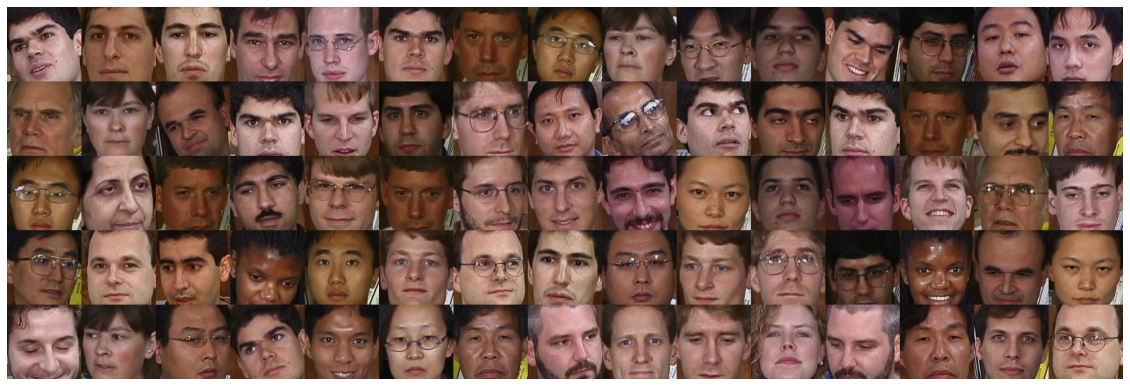

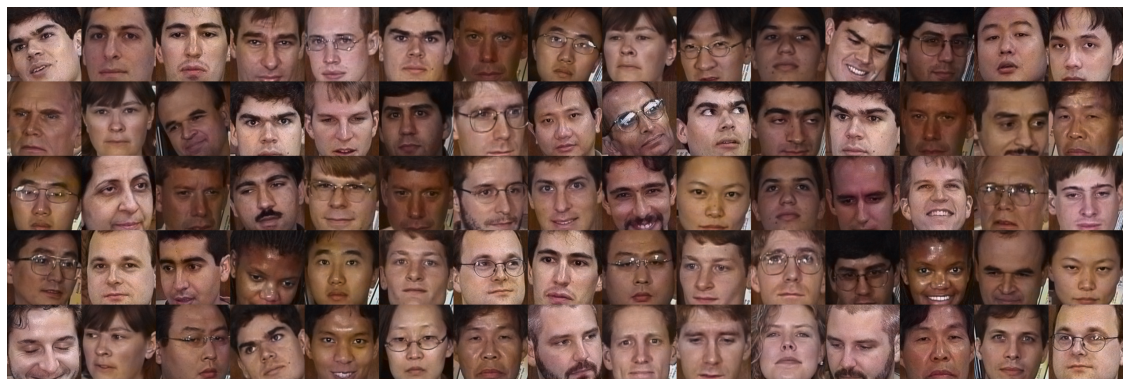

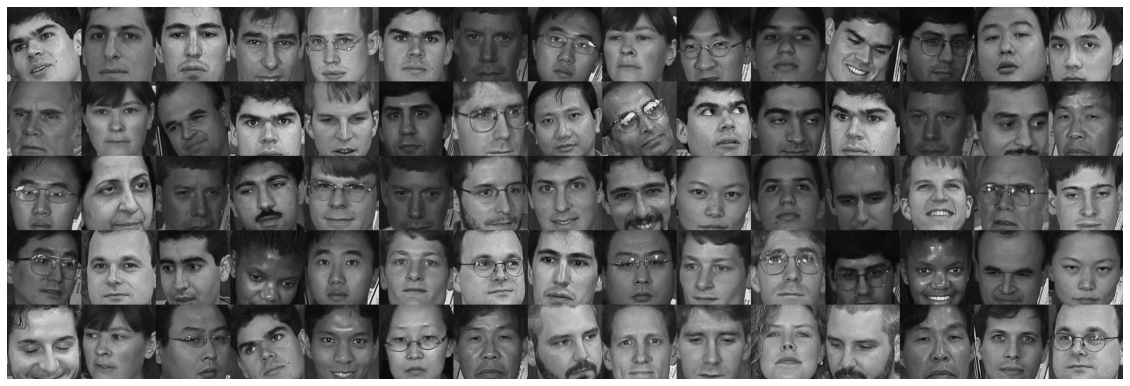

In [33]:
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(testLoader, 0):  #Get the test results.
        inputs, labels = data[0].cuda(), data[2].cuda() 
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        # print statistics
        test_loss += loss.item()
        saveRes2Img(inputs, labels, outputs)        
    n_samples = (i+1)*len(outputs)       

logStr = 'Test MSE of the network on the %d test samples: %.10f' % (n_samples, test_loss/(i+1))
trainTestLog.write(logStr+'\n') #Save training records into log.
print(logStr)
trainTestLog.close() 